# BEE 4750 Homework 3: Uncertain Sea-Level Rise and Levee Reliability

**Name**: Christine Swanson

**ID**: cms549

> **Due Date**
>
> Friday, 10/06/23, 9:00pm

## Overview

### Instructions

This assignment asks you to conduct a Monte Carlo analysis of levee
reliability in the face of uncertain changes to local sea levels. You
will propagate uncertainty in equilibrium climate sensitivity through
the energy balance model to obtain a distribution of temperatures, which
will then drive a model of sea-level rise. You will finally use this
distribution to assess the probability that a planned levee will achieve
its desired reliability standard.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `c:\Users\chris\Box\classwork\2023_Fall\BEE5750\hw\hw3-christinemswanson`


In [2]:
using Random
using Plots
using LaTeXStrings
using Distributions
using CSV
using DataFrames

## Problems (Total: 40 Points)

### Problem 1 (12 points)

Recall from class that the simple energy balance model (EBM) of
planetary energy balance links changes in radiative forcing ($F$) to
global mean temperature ($T$) changes through the discretized equation
$$T_{i+1} = T_{i} + \frac{F_i - \lambda T_i}{cd} \times \Delta t,$$
where $i$ is the current time step, $c = 4.184 \times 10^6$
J/K/m<sup>2</sup> is the heat capacity of water per unit area, $d$ is
the (uncertain) depth of the mixing layer, $\Delta t$ is the annual time
step in seconds and $\lambda = F_{\text{2xCO}_2}/S$ is the climate
feedback parameter in W/m<sup>2</sup>/$^\circ$ C, where $S$ is the
equilibrium climate sensitivity (the uncertain equilibrium temperature
change resulting from a doubling of atmospheric CO<sub>2</sub>).
Finally, while total radiative forcing can be the result of non-aerosol
and aerosol effects, we do not know the relative intensity of aerosol
forcing, so we represent this with an uncertain aerosol scaling factor
$\alpha$.

We can implement this model with the following Julia function. We will
assume an ocean mixing depth $d = 100$ m and an aerosol scaling factor
$\alpha = 1.3$ so we can focus on the uncertainty in $S$.

The last technical concern is that “global mean temperature” does not
make sense in absolute terms as a marker of climate change. Instead, we
typically refer to temperature changes relative to some historical
pre-industrial baseline. In this case, we will use the period from
1880-1900, though this choice can vary.

In [3]:
# we need to split up the aerosol and non-aerosol forcings when we call the function
function energy_balance_model(S, forcing_aerosol, forcing_non_aerosol)
    d = 100 # ocean mixing depth [m]
    α = 1.3 # aerosol scaling factor
    F2xCO₂ = 4.0 # radiative forcing [W/m²] for a doubling of CO₂
    λ = F2xCO₂/S
    
    c = 4.184e6 # heat capacity/area [J/K/m²]
    C = c*d # heat capacity of mixed layer (per area)

    F = forcing_non_aerosol + α*forcing_aerosol # radiative forcing

    Δt = 31558152.0 # annual timestep [s]
    
    T = zero(F)
    for i in 1:length(F)-1
        T[i+1] = T[i] + (F[i] - λ*T[i])/C * Δt
    end
    # return temperature anomaly relative to 1880-1900 baseline
    return T .- mean(T[1:21]) 
end

energy_balance_model (generic function with 1 method)

Finally, we need to load some radiative forcing data. We will use the
radiative forcing scenario RCP 8.5. We can load this data, which is in a
`.csv` (comma-delimited) file, into a `DataFrame`, which is a tabular
data structure. Rows and columns in a `DataFrame` can be accessed using
their numerical index (like a matrix), but columns also have names; you
can access a particular column in a dataframe `df` by name using
`df.colname` or `df[:, "colname"]`.

Of note: this data set goes from 1750–2500, so you will need to take
care to make sure you are using the right years at each step. For
example, here we will constrain the data to 1880–2100, which is the
period we are interested in.

In [4]:
# The CSV is read into a DataFrame object, and we specify that it is comma delimited
forcings_all_85 = CSV.read("data/ERF_ssp585_1750-2500.csv", DataFrame, delim=",")

# get the years corresponding to the forcings
t = Int64.(forcings_all_85[!,"year"]) # Ensure that years are interpreted as integers
# find the indices of the years 1880 and 2100
# we can do this with the indexin function
time_bounds = indexin([1880, 2100], t)
years = time_bounds[1]:time_bounds[2] # create range of years

# Separate out the individual components
forcing_co2_85 = forcings_all_85[years,"co2"]
# Get total aerosol and non-aerosol forcings
forcing_aerosol_rad_85 = forcings_all_85[years,"aerosol-radiation_interactions"]
forcing_aerosol_cloud_85 = forcings_all_85[years,"aerosol-cloud_interactions"]
forcing_aerosol_85 = forcing_aerosol_rad_85 + forcing_aerosol_cloud_85 # aerosol forcings
forcing_total_85 = forcings_all_85[years,"total"] 
forcing_non_aerosol_85 = forcing_total_85 - forcing_aerosol_85 # non-aerosol forcings

221-element Vector{Float64}:
  0.42741479112315905
  0.4487940147601447
  0.4900144276528058
 -0.019811270078689047
 -1.480725700367619
 -0.3154905163510021
  0.233186559774844
  0.2923308952663089
  0.45833872365810924
  0.5168189581089915
  ⋮
  9.879065698371564
  9.946850640754889
 10.002169546141578
 10.061009359425011
 10.115684195707905
 10.182946497594184
 10.249699157847772
 10.331407709334023
 10.424544495740134

For this assignment, you can use the `forcing_aerosol_85` and
`forcing_non_aerosol_85` vectors as is to correspond to the relevant
forcings. You will need to use the vector `t` to find the appropriate
years for analysis.

#### Problem 1.1 (3 points)

Assume that $S$ is distributed according to
$\text{LogNormal}(\log(3.2), \log({2})/3)$ (as in class). Draw 10,000
samples from this distribution and make a histogram.

In [5]:
mu = log(3.2) # mean
sigma = log(2)/3 # st. dev.

log_dist = LogNormal(mu, sigma) # set up the log distribution
draw_log = rand(log_dist, 10000); # draw 10K random samples from the log dist

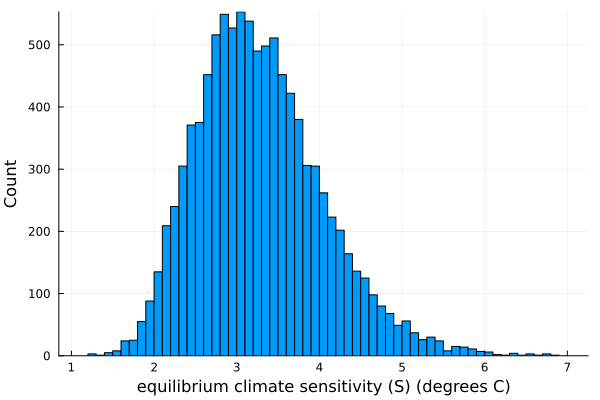

In [69]:
# plot the 10K random draws from the log dist
histogram(draw_log, xlabel = "equilibrium climate sensitivity (S) (degrees C)", ylabel = "Count", legend = false,
bins = 100) 

#### Problem 1.2 (5 points)

Use the EBM to propagate your samples of $S$ to a distribution of global
mean temperature. Plot the median and 90% predictive distribution
(between the .05 and .95 quantiles) from 1880-2100.

In [7]:
years_1880_2100 = t[131:351]; # vector of years from 1880-2100 

In [47]:
temp_values = zeros((length(draw_log), length(years_1880_2100))) # empty vectors
# to store the temperature values for each sample

# loop through S samples, propagate them using the EBM
for i_year in 1:length(draw_log)
    S = draw_log[i_year] # get current sample from S
    temp_output = energy_balance_model(S, forcing_aerosol_85, forcing_non_aerosol_85)
    temp_values[i_year, :] = temp_output # get i-th row and all columns from temp_values vector
end

The above code chunk propagates the samples of `S` using the EBM, and collects predictions of temperature. I first draw samples of `S` from my previously defined log-normal distribution. Then, my loop goes through each sample of S and calls the `energy_balance_model` function to get temperature anomaly values, which for each sample get stored in the vector called `temp_values`.  

In [48]:
# find median of vector EBM output for each year/column
temp_median = quantile.(eachcol(temp_values), 0.5);

# repeat for lower quantile, 0.05
temp_lower_quantile = quantile.(eachcol(temp_values), 0.05);

# repeat for upper quantile, 0.95
temp_upper_quantile = quantile.(eachcol(temp_values), 0.95);

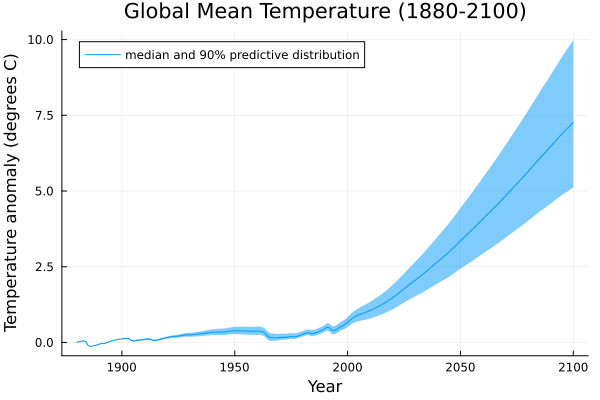

In [53]:
# plot the median and 90% predictive distribution from 1880-2100

plot(years_1880_2100, temp_median, label = "median and 90% predictive distribution", 
ribbon = (temp_median - temp_lower_quantile, temp_upper_quantile - temp_median),
xlabel = "Year", ylabel = "Temperature anomaly (degrees C)",
title = "Global Mean Temperature (1880-2100)", legend=:topleft)

#### Problem 1.3 (4 points)

Make a histogram of global mean temperature projections in 2100. If you
compare this distribution to the distribution of $S$ from Problem 1.1,
what do you observe?

In [11]:
temp_2100 = [] # vector to store 2100 temp values

for i in 1:length(draw_log)
    S = draw_log[i]
    temp_output = energy_balance_model(S, forcing_aerosol_85, forcing_non_aerosol_85)
    push!(temp_2100, temp_output[221]) # 221 = 2100 - 1880
end

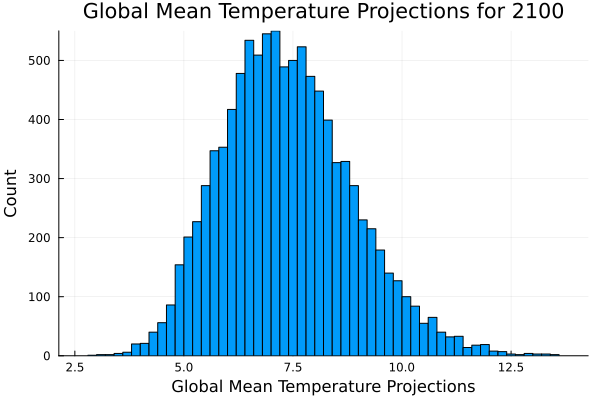

In [70]:
histogram(temp_2100, legend = false, xlabel = "Global Mean Temperature Projections",
ylabel = "Count", title = "Global Mean Temperature Projections for 2100")

Comparing my histogram of the global mean temperature projections for 2100 to the histogram of S from problem 1.1, I notice that the values from the distribution of the global mean temperature projections for 2100 tend to be higher than what is shown in the distribution from problem 1.1. But, importantly, the distribution from problem 1.1 is showing the distribution of values for S, whereas my histogram from this problem is showing the distribution of the values for global mean temperature. Another observation pertains to the spread in the data between the two distributions. The S values from problem 1.1 seem to range from around 1 to 7, whereas the projections from problem 1.3 seem to range from around 2 to 13 (wider range). One possible reasoning is because global mean temperature is a function of S, which is an uncertain value in this case. I am propogating uncertainties in S when running the energy balance model.  

### Problem 2 (15 points)

Changes to global temperatures cause changes in global sea levels
through several mechanisms, including thermal expansion (the change in
ocean volume due to increased heat content) and melting land-based ice.
One simple way to represent this link is through the following model,
proposed by [Rahmstorf (2007)](https://doi.org/10.1126/science.1135456).

$$\frac{dH}{dt} = a(T-T_0),$$

where $H$ is the global mean sea level in mm, $T$ is global mean
temperature, $T_0$ is an equilibrium temperature (where there is no
change in sea levels), and $a$ is a proportionality constant. This model
can be discretized to give $$H_{i+1} - H_i = a (T_i - T_0).$$

Note that, like with global mean temperature, the notion of “global mean
sea level” does not make sense in absolute terms (were sea levels ever
at “zero”?). Instead, we want to normalize this relative to some
historical baseline. In this case (with a view towards Problem 3), we
will compute our sea levels relative to the 2010 sea level. Note that in
addition to the model parameters, we also need an initial sea-level
parameter $H_0$ which will give us the right anomaly level.

The best estimates for these parameters are:

-   $a = 1.86$;
-   $H_0 = -223$;
-   $T_0 = -0.62$

#### Problem 2.1 (5 points)

Write a function `sea_level_model()` to implement the mathematical
sea-level rise model described above. It should take in needed
parameters and a vector of temperatures and return a vector of sea
levels. To test your function, use the provided temperature series
`historical_temps` (read in below) to compute the global mean sea level
anomaly in 2022 (the last year of the dataset) with the parameter values
above; you should get a value of approximately 40mm.

In [13]:
historical_temp_data = CSV.read("data/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv", DataFrame, delim=",")
# column 2 is the temperature anomaly, column 1 is the year
temp_bds = indexin([1880, 1900], historical_temp_data[!, 1]) # find the index of 2010 for normalization
historical_temp_data[:, 2] .-= mean(historical_temp_data[temp_bds[1]:temp_bds[2], 2])
historical_temps = historical_temp_data[temp_bds[1]:end, 2]

143-element Vector{Float64}:
  0.07297116761904765
  0.15655772761904765
  0.09327316761904769
  0.04232884761904765
 -0.10351681238095234
 -0.08232033238095232
 -0.03210037238095231
 -0.10998251238095236
  0.00942435761904764
  0.13890768761904768
  ⋮
  1.0616748976190478
  1.2139176176190476
  1.3217303776190477
  1.2339774976190476
  1.1514572476190477
  1.2798758476190477
  1.3115970476190477
  1.1506591476190478
  1.1896871476190476

In [59]:
# function to take in a vector of temperatures and return a vector of sea levels
function sea_level_model(temp_vec, a = 1.86, H0 = -223, T0 = -0.62)

    H = zeros(length(temp_vec)) # vector to store sea level changes 
    H[1] = H0 # initial sea level value 

    baseline_year = 2010
    starting_year = 1880
    index_baseline = baseline_year - starting_year + 1 # calculate baseline year's index

    for i_val in 2:length(temp_vec) # loop through temp vector starting at second element 
        H[i_val] = H[i_val-1] + a*(temp_vec[i_val-1] - T0) 
    end

    # normalize sea levels relative to 2010 baseline 
    normalization = H[index_baseline] # get baseline sea level value 
    
    return H .- normalization # normalization step 
end

sea_level_model (generic function with 4 methods)

In [60]:
# test the function 
print("The 2022 global mean sea level anomaly is: ", round(sea_level_model(historical_temps)[end]; digits = 2), " mm")

1The 2022 global mean sea level anomaly is: 39.32 mm

Indeed, I got a value of around 40 mm for the global MSL anomaly in 2022 using my function. 

#### Problem 2.2 (5 points)

Evaluate `sea_level_model()` using the projected temperature ensemble
from Problem 1. Plot the 90% projection interval of the sea levels.

In [41]:
# test code...FIX THIS TO MAKE IT SIMPLER/BETTER VARIABLE NAMES!
# this code is more concise than what I used for problem 1.2, 
# but I do not want to go back and fix problem 1.2 because it still works
temp_samples = [energy_balance_model(S, forcing_aerosol_85, forcing_non_aerosol_85) for S in draw_log];
sea_samples = [sea_level_model(temp) for temp in temp_samples];

In [42]:
# again, update this code to avoid using hcat, etc.
sea_samples_matrix = hcat(sea_samples...)' # make 2D matrix from sea_samples 

# compute median, upper and lower quantiles 
sea_level_05 = [quantile(sea_samples_matrix[:,i], 0.05) for i in 1:length(t[years])];
sea_level_95 = [quantile(sea_samples_matrix[:,i], 0.95) for i in 1:length(t[years])];
sea_level_50 = [median(sea_samples_matrix[:,i]) for i in 1:length(t[years])];

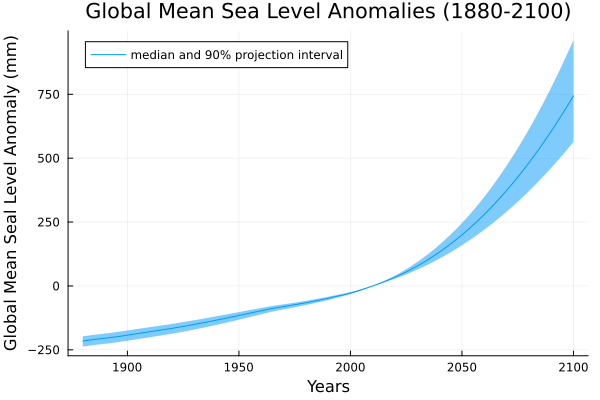

In [55]:
plot(t[years], sea_level_50, ribbon = (sea_level_50 .- sea_level_05, sea_level_95 .- sea_level_50),
label = "median and 90% projection interval", xlabel = "Years", ylabel = "Global Mean Seal Level Anomaly (mm)",
legend=:topleft, title = "Global Mean Sea Level Anomalies (1880-2100)")

#### Problem 2.3 (5 points)

Make a histogram of the sea-level anomaly in 2100. What can you observe
about how the ECS uncertainty has impacted sea-level uncertainty under
this radiative forcing scenario? What might the implications be of only
using the best-estimate ECS value?

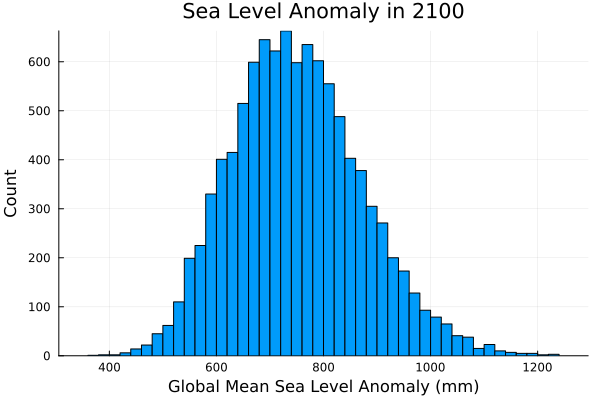

In [71]:
# go through each sample in sea level samples and just extract the 2100 data
sea_data_2100 = [sea_level_sample[end] for sea_level_sample in sea_samples];

histogram(sea_data_2100, title = "Sea Level Anomaly in 2100", xlabel = "Global Mean Sea Level Anomaly (mm)",
ylabel = "Count", legend = false)

I can see that the ECS (S) uncertainty has impacted sea-level uncertainty in this scenario, as the distribution of possible global mean sea level anomalies is quite large for 2100. The values for global MSL for 2100 range from roughly 400 mm to 1200 mm, which is a wide distribution. From my plot from 2.2, I can clearly see that the uncertainties in global MSL increase through time after 2010, and these uncertainties are most extreme in 2100. The implications of using only one "best-estimate" ECS value is that we are not propograting uncertainty into our results. In particular, from our class discussions, using only one ECS value might capture the overall trend, but not the details (e.g., we might see over/under-estimation by the model at various points in time). So, by incorporating uncertainty propogration into the above analyses, we can quantify the impact of "upstream" uncertainties on the system outputs. Direct implications of just using one ECS value is that we would be limiting ourselve to prepaare for one scneario for sea level rise, which is risky if that outcome does not occur (i.e., this is not a robust adaptation approach towards mitigating climate change).   

### Problem 3 (13 points)

You’ve been asked to consult on a levee reliability analysis. For
context, levees in the United States are supposed to only fail once in
100 years, or, in other words, to have at most a 1% chance of failure in
a given year. We will assume for this problem that the only way in which
a levee fails is by being overtopped (note: this is unrealistic).

We can assess the probability of levee overtopping by comparing its
height to a distribution of extreme sea levels. A common approach is to
look at the distribution of the highest sea level each year. These
extreme sea levels can be obtained by combining the absolute sea level
(we will use our distribution of global sea levels for this), the rate
of subsidence (how much the ground sinks), and the distribution of storm
tides (the highest tide level, which is often the result of storm surges
combining with high tide).

Assume for this problem that:

1.  the annual rate of subsidence $\nu$ is 1.2mm/yr;
2.  the distribution of annual storm tide maxima, above the mean sea
    level, is (and is expected to continue to be) given by a
    $\text{GeneralizedExtremeValue}(900, 25, 0.3)$ distribution, which
    looks like this:

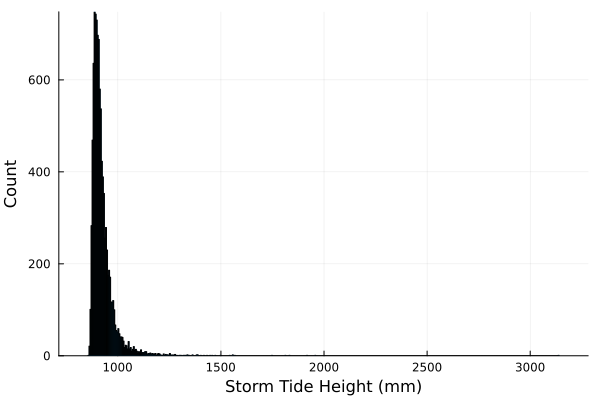

In [20]:
tide_distribution = GeneralizedExtremeValue(900, 25, 0.3)
    histogram(rand(tide_distribution, 10000), xlabel="Storm Tide Height (mm)", ylabel="Count", legend=:false)

Feel free to just sample from `tide_distribution` in your solution
below.

#### Problem 3.1 (2 points)

How would you use your sea-level simulations and the above information
to compute a distribution of extreme sea levels in 2100 relative to 2010
mean sea level? Write down the approach in clear steps, with equations
as needed.

**Response**: The way I approached this problem was by paying close attention to the units involved with the parameters in the problem. Because we have: 

Extreme Sea Level = (absolute sea level [mm]) + (subsidence [mm/yr]) + (distribution of storm tides [mm]), 

then we know that we need to multiply by our years of interest to cancel out the years in the denominator of the units for the subsidence rate. Thus, to compute the distribution of extreme sea levels in 2100 relative to the 2010 mean sea level, we can implement the following approach: 

**Step 1**: Define necessary parameters, including:
- The subsidence rate over time (v*t), where t = (2100 - 2010 + 1)
- The samples to draw from the tide distribution to get the max tide

**Step 2**: Loop through each sample in the sea level samples from 2100 from question 2
- In the loop calculate the extreme sea level as follows: 

Extreme Sea Level = (sea level value from 2100) + (subsidence rate over time) + (tide distribution samples)

**Step 3**: return the Extreme Sea Level vector and plot the histogram

#### Problem 3.2 (3 points)

Follow the steps above and produce a histogram of the extreme sea levels
in 2100 relative to 2010.

In [79]:
# code to produce histogram of extreme sea levels in 2100 relative to 2010

v = 1.2 # [mm/yr]
subsidence_rate_time = v*(2100 - 2010 + 1)
draw_tide_dist = rand(tide_distribution, 10000) # draw from the tide_distribution 

extreme_SL_2100 = [] # initialize vector to store extreme sea levels
for sea_val in sea_data_2100
    extreme_SL_2100 = sea_val .+ subsidence_rate_time .+ draw_tide_dist
end 
return extreme_SL_2100;

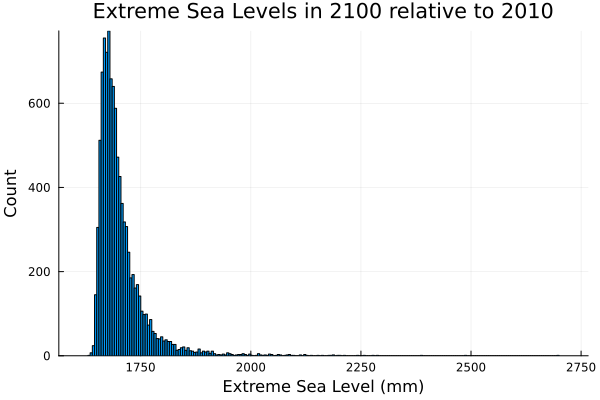

In [88]:
histogram(extreme_SL_2100, xlabel = "Extreme Sea Level (mm)", ylabel = "Count", legend = false,
title = "Extreme Sea Levels in 2100 relative to 2010")

#### Problem 3.3 (5 points)

The current levee was heightened in 2010 to 2m above the 2010 mean sea
level. Based on your analysis above, what is the probability that the
levee will be overtopped in 2100 (remember that the reliability standard
is 1%)?

#### Problem 3.4 (3 points)

Based on your analysis, would you recommend that the levee be heightened
again in the future, and if so, how high? What other information might
you need, if any, to make your recommendation?

## References

List any external references consulted, including classmates.